# Comparison of the same experiment in different battery charging levels.

The objective is to see if the varying voltage from the Ion-Lithium battery will interfere with the comparison of energy measurements.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from codes.clean import clean_energy_data
from codes.transform import remove_delay

## Experiments

Three experiments were made by running a CPU stress test from stress-ng in three different battery levels (i.e. 50%, 60%, 70% of total battery capacity)

In [2]:
temp = {}

for capacity in range(50, 101, 10):
    temp[str(capacity)] = pd.read_csv(f'csvfiles/stress/compare-ackermann-{capacity}.csv')

In [3]:
battery_data = {}

# Cleaning spurious data from the start of the experiment when the phone was still charging
for capacity, data in temp.items():
    mask = data['current_avg'] < 0
    battery_data[capacity] = data[mask]

In [4]:
clean_battery = {capacity: clean_energy_data(data) for capacity, data in battery_data.items()}

clean_battery['70'].head()

timestamp  iteration   little      big  \
datetime                                                              
2019-11-25 16:47:31.664  1574700451664          0  1568000  2148000   
2019-11-25 16:47:32.226  1574700452226          0  1568000  2148000   
2019-11-25 16:47:32.786  1574700452786          0  1568000  2148000   
2019-11-25 16:47:33.340  1574700453340          0  1568000  2148000   
2019-11-25 16:47:33.885  1574700453885          0  1568000  2148000   

                         thermalzone_temp0  thermalzone_temp1  \
datetime                                                        
2019-11-25 16:47:31.664                550                550   
2019-11-25 16:47:32.226                560                570   
2019-11-25 16:47:32.786                590                590   
2019-11-25 16:47:33.340                600                590   
2019-11-25 16:47:33.885                580                570   

                         thermalzone_temp2  thermalzone_temp3  \
datetime                                                        
2019-11-25 16:47:31.664                410                291   
2019-11-25 16:47:32.226                420                291   
2019-11-25 16:47:32.786                430                291   
2019-11-25 16:47:33.340                440                291   
2019-11-25 16:47:33.885                450                291   

                         thermalzone_temp4  current_now  current_avg  \
datetime                                                               
2019-11-25 16:47:31.664                266       -1.013       -0.126   
2019-11-25 16:47:32.226                266       -1.013       -0.126   
2019-11-25 16:47:32.786                266       -1.013       -0.126   
2019-11-25 16:47:33.340                266       -1.013       -0.126   
2019-11-25 16:47:33.885                266       -1.013       -0.126   

                         voltage_now  voltage_avg  batt_temp  capacity health  \
datetime                                                                        
2019-11-25 16:47:31.664        4.002        4.002       26.6        73   GOOD   
2019-11-25 16:47:32.226        4.002        4.002       26.5        73   GOOD   
2019-11-25 16:47:32.786        4.002        4.002       26.5        73   GOOD   
2019-11-25 16:47:33.340        4.002        4.002       26.5        73   GOOD   
2019-11-25 16:47:33.885        4.002        4.002       26.5        73   GOOD   

                              status     power  
datetime                                        
2019-11-25 16:47:31.664  DISCHARGING  0.004054  
2019-11-25 16:47:32.226  DISCHARGING  0.004054  
2019-11-25 16:47:32.786  DISCHARGING  0.004054  
2019-11-25 16:47:33.340  DISCHARGING  0.004054  
2019-11-25 16:47:33.885  DISCHARGING  0.004054

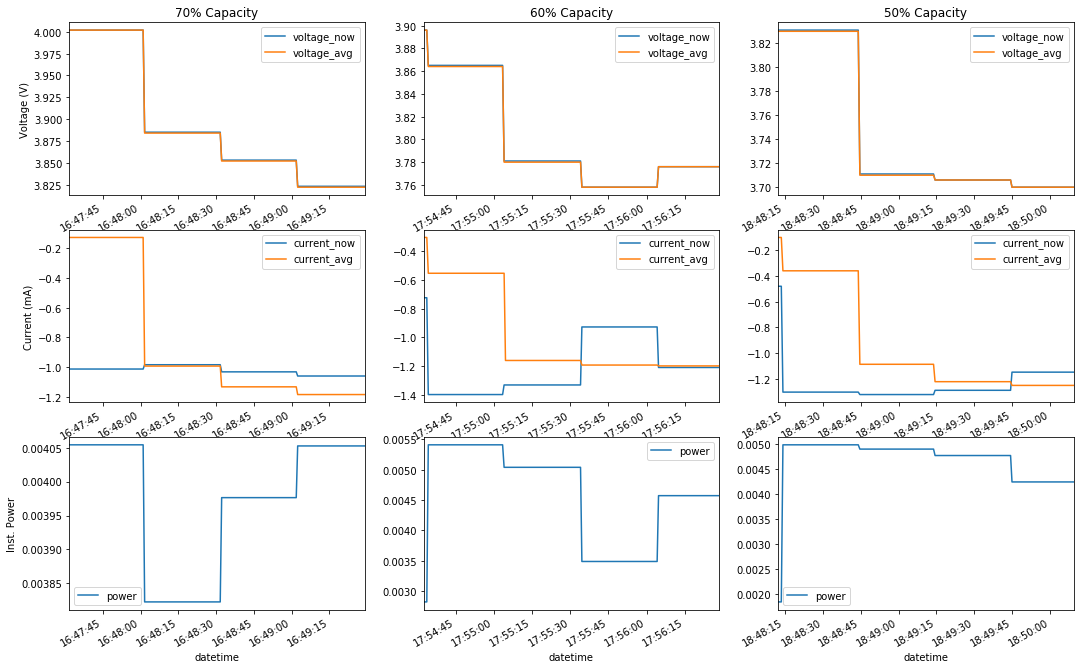

In [5]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))

# Columns to be compared
columns = [['voltage_now', 'voltage_avg'],
            ['current_now', 'current_avg'],
            ['power']]

# Titles
axs[0][0].set_title('70% Capacity')
axs[0][1].set_title('60% Capacity')
axs[0][2].set_title('50% Capacity')

# Rows
axs[0][0].set_ylabel('Voltage (V)')
axs[1][0].set_ylabel('Current (mA)')
axs[2][0].set_ylabel('Inst. Power')

for idx, column in enumerate(columns):
    clean_battery['70'][column].plot(ax=axs[idx][0])
    clean_battery['60'][column].plot(ax=axs[idx][1])
    clean_battery['50'][column].plot(ax=axs[idx][2])

In [6]:
battery_wd = {capacity: remove_delay(data) for capacity, data in clean_battery.items()}

battery_wd['70'][['voltage_now', 'voltage_avg']].head()

voltage_now  voltage_avg
timestamp                          
0                4.002        4.002
562              4.002        4.002
1122             4.002        4.002
1676             4.002        4.002
2221             4.002        4.002

In [7]:
columns = [data['power'] for data in battery_wd.values()]
keys = [f'{capacity}%' for capacity in battery_wd]

powers = pd.concat(columns, axis=1, keys=keys)

# Uses ffill to remove NaN that are caused due to timestamps not being spread exactly half a second apart
powersf = powers.ffill()

# Transforms timestamps from milliseconds to seconds
powersf.index = powersf.index.map(lambda milli: milli / 1000)

# Integrate instantaneous power (values) over time (index)
energy = powersf.apply(lambda x: np.trapz(x.values, x.index))

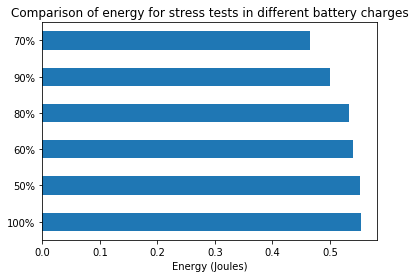

In [8]:
energy.sort_values(ascending=False).plot(kind='barh')
plt.title('Comparison of energy for stress tests in different battery charges')
_ = plt.xlabel('Energy (Joules)')

plt.savefig('images/comparison-battery.png')